In [1]:
import glob
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot 
from astropy import units as u 
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from utils import merge_hdf_files, calc_angular_separation

In [2]:
# --- ignore warnings ---
warnings.simplefilter('ignore')

# --- display all columns --- 
pd.set_option('display.max_columns', None)

# --- customize pyplot figure ---
pyplot.rcParams['figure.figsize'] = (12, 9)
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['grid.linestyle'] = ':'

# --- get the default color cycle ---
color_cycle = pyplot.rcParams['axes.prop_cycle'].by_key()['color']

# Load DL2 data

In [3]:
data_mask = '/home/yoshiki.ohtani/Crab/2020_*/4.dl1_to_dl2/data/dl2/merged/*.h5'

In [4]:
np.sort(glob.glob(data_mask))

array(['/home/yoshiki.ohtani/Crab/2020_11_18/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run02923.h5',
       '/home/yoshiki.ohtani/Crab/2020_11_18/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run02924.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_13/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03234.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_13/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03235.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03265.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03266.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03267.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03268.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_22/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03382.h5',
       '/home/yoshiki.ohtani/Crab/2020_12_22/4.dl1_to_dl2/data/dl2/merged

In [5]:
tel_combinations = {
    'm1_m2': [2, 3],   # event_type = 0
    'lst1_m1': [1, 2],   # event_type = 1
    'lst1_m2': [1, 3],   # event_type = 2
    'lst1_m1_m2': [1, 2, 3]   # event_type = 3
}

# --- load/merge the input data ---
data_joint = merge_hdf_files(data_mask, n_files=5)
data_joint.sort_index(inplace=True)

# --- check the number of events ---
n_events_total = len(data_joint.groupby(['obs_id', 'event_id']).size()) 
print(f'\nIn total {n_events_total} stereo events:') 

for event_type, (tel_combo, tel_ids) in enumerate(zip(tel_combinations.keys(), tel_combinations.values())):

    df = data_joint.query(f'(tel_id == {tel_ids}) & (multiplicity == {len(tel_ids)})')
    df['multiplicity'] = df.groupby(['obs_id', 'event_id']).size()
    df.query(f'multiplicity == {len(tel_ids)}', inplace=True)
    
    n_events = len(df.groupby(['obs_id', 'event_id']).size())
    print(f'{tel_combo}: {n_events} events ({n_events/n_events_total*100:.1f}%)')
    
    data_joint.loc[df.index, 'event_type'] = event_type
    
print('\nDone.')


Merging the input data to subsets:
/home/yoshiki.ohtani/Crab/2020_11_18/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run02923.h5
/home/yoshiki.ohtani/Crab/2020_11_18/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run02924.h5
/home/yoshiki.ohtani/Crab/2020_12_13/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03234.h5
/home/yoshiki.ohtani/Crab/2020_12_13/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03235.h5
/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03265.h5
--> /home/yoshiki.ohtani/Crab/2020_11_18/4.dl1_to_dl2/data/dl2/merged/subset_dl2_lst1_magic_Run02923_to_dl2_lst1_magic_Run03265.h5

/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03266.h5
/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03267.h5
/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run03268.h5
/home/yoshiki.ohtani/Crab/2020_12_22/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_Run0338

In [6]:
data_joint.head(10)

obs_id_lst  event_id_lst    intensity         x  \
obs_id  event_id tel_id                                                    
5093174 2122     1           2923.0     2054288.0   349.439157 -0.449816   
                 2              NaN           NaN   108.671875  0.027797   
        2126     1           2923.0     2054414.0    80.912809  0.055519   
                 2              NaN           NaN   176.444987  0.319373   
        2130     1           2923.0     2054693.0   524.551555 -0.658167   
                 2              NaN           NaN   309.348958 -0.267904   
                 3              NaN           NaN   268.299479 -0.314013   
        2132     1           2923.0     2054766.0  1642.222234  0.142298   
                 2              NaN           NaN   682.101041  0.219247   
                 3              NaN           NaN   830.125000  0.211807   

                                y         r         phi    length     width  \
obs_id  event_id tel_id                                                       
5093174 2122     1       0.488431  0.664002  132.643273  0.172361  0.098847   
                 2       0.335385  0.336535   85.262067  0.085343  0.017875   
        2126     1      -0.122446  0.134445  -65.609643  0.047792  0.023218   
                 2       0.086378  0.330847   15.134165  0.092057  0.019301   
        2130     1       0.087770  0.663994  172.404089  0.091635  0.038870   
                 2       0.084833  0.281014  162.429424  0.044108  0.027682   
                 3       0.010559  0.314191  178.074182  0.054217  0.025034   
        2132     1      -0.205861  0.250255  -55.346518  0.131862  0.046486   
                 2      -0.123636  0.251705  -29.419061  0.100258  0.039357   
                 3      -0.165825  0.268999  -38.057629  0.094508  0.030039   

                               psi  skewness  kurtosis      slope  intercept  \
obs_id  event_id tel_id                                                        
5093174 2122     1       11.072326  0.666131  2.381397  -5.960761  18.273785   
                 2      -25.261473 -0.350821  1.301270 -34.581244  24.588408   
        2126     1       10.871297 -0.162843  1.640460 -11.523663  12.038087   
                 2       53.087812 -0.118283  1.591619   5.621121  19.194418   
        2130     1       49.454299 -0.505543  2.924984  -3.162736  19.461778   
                 2       80.681458  0.067720  2.347090   8.129355  23.720379   
                 3       71.841862 -0.396296  2.513928  -4.637644  23.516860   
        2132     1       30.518596 -1.645358  6.664997 -13.188983  20.123361   
                 2       65.294646 -0.720628  2.653032  11.765283  25.814252   
                 3       80.270400  0.379087  4.620778  -9.410676  30.949368   

                         intensity_width_1  intensity_width_2  pixels_width_1  \
obs_id  event_id tel_id                                                         
5093174 2122     1                     0.0           0.000000             0.0   
                 2                     0.0           0.000000             0.0   
        2126     1                     0.0           0.000000             0.0   
                 2                     0.0           0.026655             0.0   
        2130     1                     0.0           0.000000             0.0   
                 2                     0.0           0.000000             0.0   
                 3                     0.0           0.000000             0.0   
        2132     1                     0.0           0.000000             0.0   
                 2                     0.0           0.000000             0.0   
                 3                     0.0           0.000000             0.0   

                         pixels_width_2  n_pixels  n_islands    alt_tel  \
obs_id  event_id tel_id                                                   
5093174 2122     1             0.000000        25          3  44.939232   
    

### Arrange the DL2 data frame

In [7]:
print('Arrange the data frame...')

params = ['ra_tel_mean', 'dec_tel_mean', 'reco_ra_mean', 'reco_dec_mean', 'dist_min',
          'reco_energy_mean', 'gammaness_mean', 'timestamp', 'event_type']

data_dl2 = data_joint[params]
data_dl2 = data_dl2.groupby(['obs_id', 'event_id']).mean()
data_dl2.dropna(inplace=True)

# --- exclude M1+M2 events due to poor reconstruction ---
data_dl2.query('event_type != 0', inplace=True)

print(f'--> {len(data_dl2)} events')

Arrange the data frame...
--> 1263954 events


In [8]:
data_dl2.head()

ra_tel_mean  dec_tel_mean  reco_ra_mean  reco_dec_mean  \
obs_id  event_id                                                           
5093174 2122        83.965556     22.246331     82.873339      21.548196   
        2126        83.965557     22.246333     81.986334      22.060189   
        2130        83.966938     22.246320     84.536567      21.241446   
        2132        83.966939     22.246320     83.066261      22.534967   
        2134        83.966939     22.246321     84.106765      22.277402   

                  dist_min  reco_energy_mean  gammaness_mean     timestamp  \
obs_id  event_id                                                             
5093174 2122      0.773722          0.459766        0.003333  1.605743e+09   
        2126      1.171994          0.185933        0.025905  1.605743e+09   
        2130      0.081068          0.393008        0.903389  1.605743e+09   
        2132      0.317142          0.973682        0.234556  1.605743e+09   
        2134      3.420255          0.125925        0.009008  1.605743e+09   

                  event_type  
obs_id  event_id              
5093174 2122             1.0  
        2126             1.0  
        2130             3.0  
        2132             3.0  
        2134             3.0

# Calculate angular separation

Observation ID: 5093174


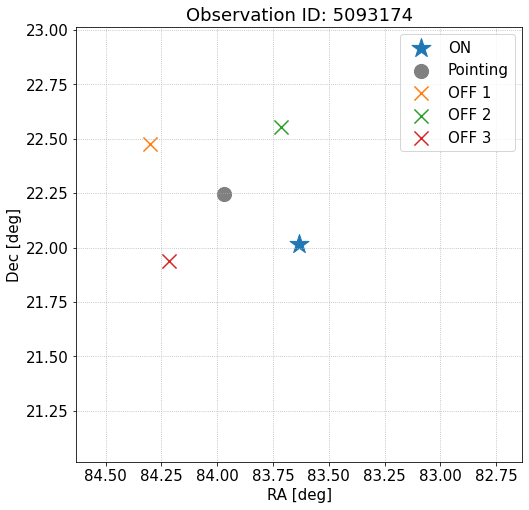

Observation ID: 5093175


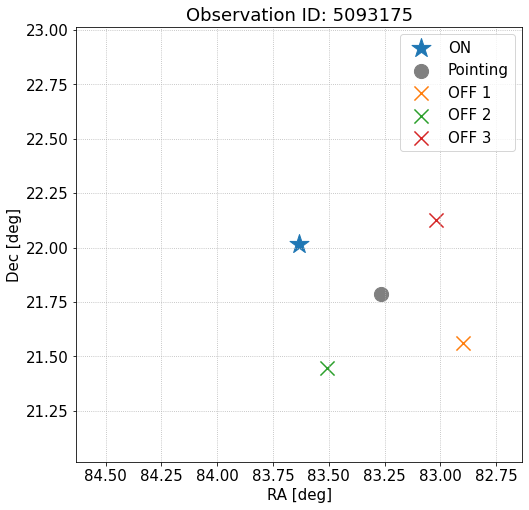

Observation ID: 5093663


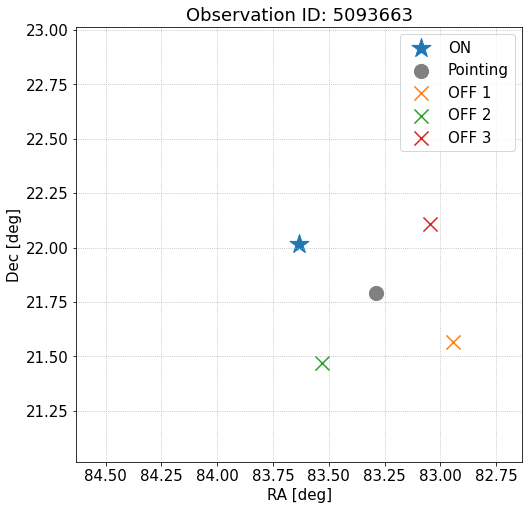

Observation ID: 5093664


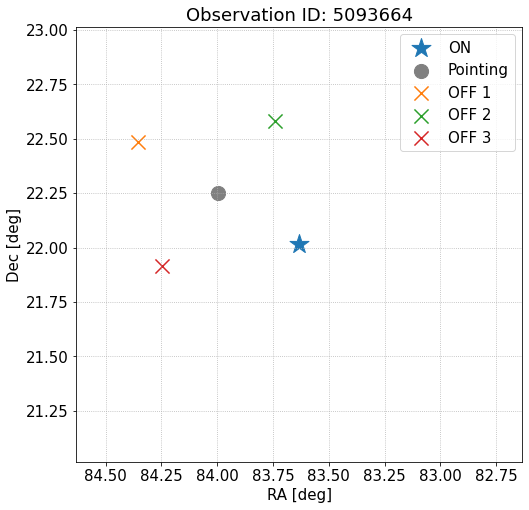

Observation ID: 5093711


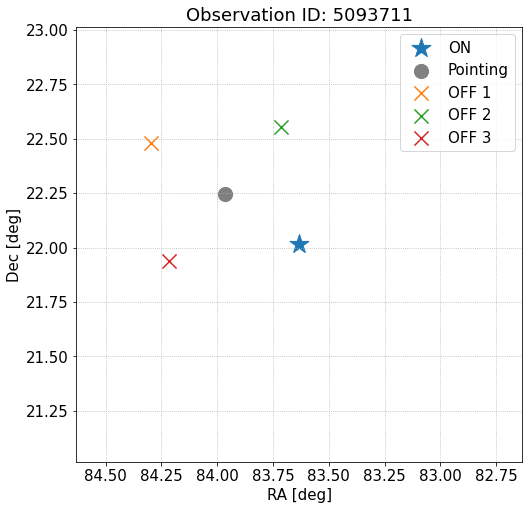

Observation ID: 5093712


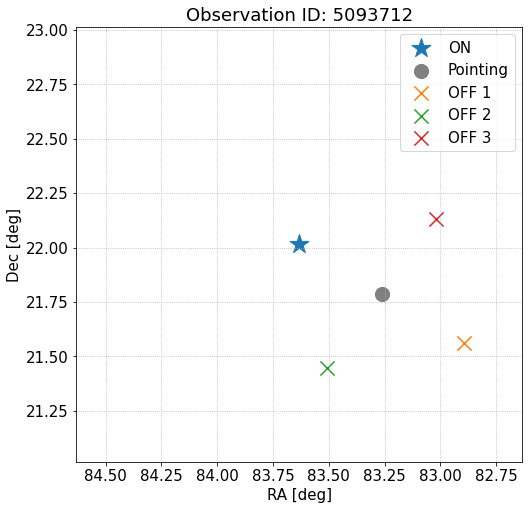

Observation ID: 5093713


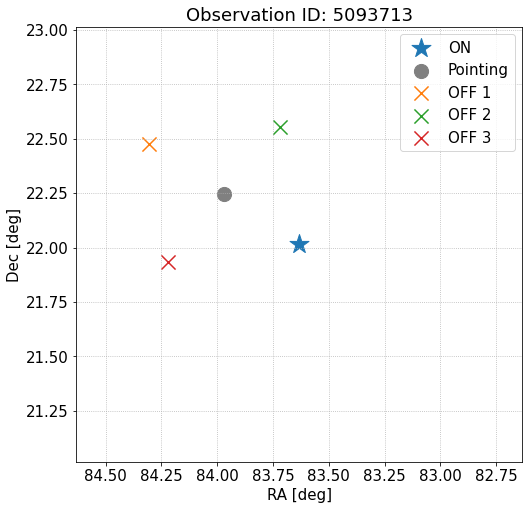

Observation ID: 5093714


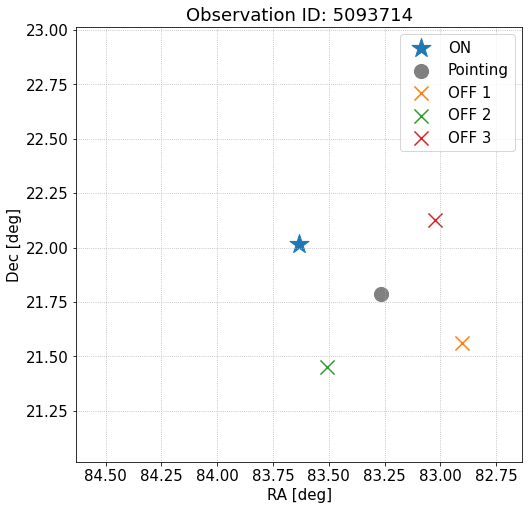

Observation ID: 5094024


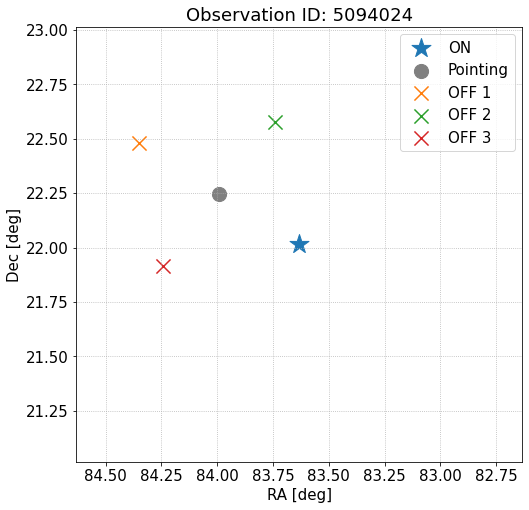

Observation ID: 5094025


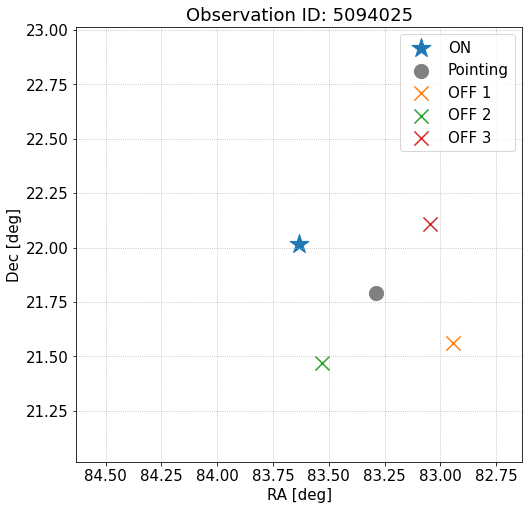

In [9]:
# ================
# === settings ===
# ================

source_name = 'Crab'
n_off_region = 3
half_width = u.Quantity(1, u.deg)

# ============
# === main ===
# ============

on_coord = SkyCoord.from_name(source_name)
on_coord = on_coord.transform_to('icrs')

xlim = [(on_coord.ra + half_width).value, (on_coord.ra - half_width).value]
ylim = [(on_coord.dec - half_width).value, (on_coord.dec + half_width).value]

observation_ids = np.unique(data_dl2.index.get_level_values('obs_id'))

for obs_id in observation_ids:
    
    print(f'Observation ID: {obs_id}')
    
    df = data_dl2.query(f'obs_id == {obs_id}')
    
    event_coords = SkyCoord(
        frame='icrs',
        ra=u.Quantity(df['reco_ra_mean'].values, u.deg),
        dec=u.Quantity(df['reco_dec_mean'].values, u.deg)
    )
    
    tel_coords = SkyCoord(
        frame='icrs',
        ra=u.Quantity(df['ra_tel_mean'].values, u.deg),
        dec=u.Quantity(df['dec_tel_mean'].values, u.deg) 
    )
    
    # --- calculate the angular separation ---
    theta_on, theta_off, off_coords = calc_angular_separation(
        on_coord, event_coords, tel_coords, n_off_region
    )
    
    data_dl2.loc[(obs_id, slice(None)), 'theta2_on'] = theta_on.to(u.deg).value**2
    
    for i_off in theta_off.keys():
        data_dl2.loc[(obs_id, slice(None)), f'theta2_off{i_off}'] = theta_off[i_off].to(u.deg).value**2
        
    # --- plot the coordinates ---
    pyplot.figure(figsize=(8, 8))
    pyplot.title(f'Observation ID: {obs_id}')
    pyplot.xlabel('RA [deg]')
    pyplot.ylabel('Dec [deg]')
    pyplot.xlim(xlim)
    pyplot.ylim(ylim)
    pyplot.axis(xlim+ylim)

    pyplot.scatter(
        on_coord.ra.value, on_coord.dec.value, label='ON', marker='*', s=400
    )

    pyplot.scatter(
        tel_coords.ra.mean().value, tel_coords.dec.mean().value,
        label='Pointing', marker='o', s=200, color='grey'
    )
    
    for i_off in off_coords.keys():
        
        pyplot.scatter(
            off_coords[i_off].ra.value, off_coords[i_off].dec.value, 
            label=f'OFF {i_off}', marker='x', s=200, color=color_cycle[i_off]
        )
    
    pyplot.grid()
    pyplot.legend()

    pyplot.show()
    pyplot.close()


# Check signal from source

### Function to find cuts to maximize the significance

In [10]:
def get_best_cuts_signif(data, bins_gamcut, bins_t2cut, n_off_region):
    
    print('Checking parameter cuts to maximize the significance...')
    
    n_bins_gamcut = len(bins_gamcut)
    n_bins_t2cut = len(bins_t2cut)

    bins_gamcut = np.repeat(bins_gamcut, n_bins_t2cut)
    bins_t2cut = np.tile(bins_t2cut, n_bins_gamcut)

    significances = []

    for gamcut, t2cut in zip(bins_gamcut, bins_t2cut):

        df = data.query(f'gammaness_mean > {gamcut}')

        n_on_obs = len(df.query(f'theta2_on < {t2cut}'))
        n_off_obs = np.sum([len(df.query(f'theta2_off{i_off+1} < {t2cut}')) for i_off in range(n_off_region)])

        alpha = 1/n_off_region

        stat = WStatCountsStatistic(n_on_obs, n_off_obs, alpha=alpha)
        signif = stat.sqrt_ts

        significances.append(signif)

    significances = np.array(significances)
    index_at_max = np.where(significances == significances.max())[0][0]

    gamcut_best = bins_gamcut[index_at_max]
    t2cut_best = bins_t2cut[index_at_max]
    
    return gamcut_best, t2cut_best

### Check theta2 distributions and significance

Checking parameter cuts to maximize the significance...

Parameter cuts: (gammaness, theta2) = (0.75, 0.025)

N_on = 2481
N_off = 1415
(alpha = 0.333)

N_excess = 2009.3
obs_time = 133.3 min
--> excess_rate = 15.1 [1 / min]

Li&Ma significance = 50.9 sigma



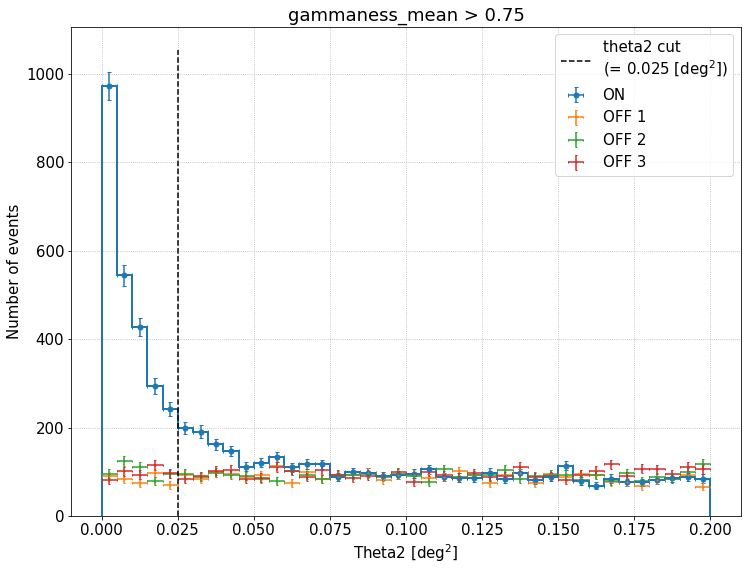

In [11]:
# ================
# === settings ===
# ================

df = pd.concat([
#     data_dl2.query('(event_type == 1) & (dist_min < 0.22)'), 
#     data_dl2.query('(event_type == 2) & (dist_min < 0.22)'), 
    data_dl2.query('(event_type == 3) & (dist_min < 0.9)'),
])

bins_theta2 = np.linspace(0, 0.2, 41)

bins_gamcut = np.round(np.arange(0.5, 0.91, 0.05), 2)
bins_t2cut = np.round(np.arange(0.01, 0.051, 0.005), 3)
gamcut, t2cut = get_best_cuts_signif(df, bins_gamcut, bins_t2cut, n_off_region) 

# gamcut = 0.8
# t2cut = 0.03

# ============
# === main ===
# ============

print(f'\nParameter cuts: (gammaness, theta2) = ({gamcut}, {t2cut})')

df_gamcut = df.query(f'gammaness_mean > {gamcut}')

bins_center = (bins_theta2[:-1] + bins_theta2[1:])/2
xerr = [bins_center - bins_theta2[:-1], bins_theta2[1:] - bins_center]

# --- plot theta2 distributions --
pyplot.figure()
pyplot.title(f'gammaness_mean > {gamcut}')
pyplot.xlabel('Theta2 [deg$^2$]')
pyplot.ylabel('Number of events')

hist = pyplot.hist(df_gamcut['theta2_on'].values, bins_theta2, histtype='step', linewidth=2)[0]

pyplot.errorbar(
    x=bins_center, xerr=xerr, y=hist, yerr=np.sqrt(hist), 
    fmt='o', capsize=2, markersize=5, label='ON', color=color_cycle[0]
)

for i_off in range(n_off_region):
    
    hist, _ = np.histogram(df_gamcut[f'theta2_off{i_off+1}'].values, bins_theta2)
    
    pyplot.errorbar(
        x=bins_center, xerr=xerr, y=hist, yerr=np.sqrt(hist), 
        fmt='o', capsize=1, markersize=1, label=f'OFF {i_off+1}'
    )
    
pyplot.plot(
    (t2cut, t2cut), (0, pyplot.ylim()[1]), 
    linestyle='--', color='black', label=f'theta2 cut\n(= {t2cut} [deg$^2$])'
)

pyplot.grid()
pyplot.legend()
    
# --- calculate the significance ---
times_first = df.groupby(['obs_id'])['timestamp'].first()
times_last = df.groupby(['obs_id'])['timestamp'].last()

obs_time = (times_last - times_first).sum()
obs_time = u.Quantity(obs_time, u.s)

n_on_obs = len(df_gamcut.query(f'theta2_on < {t2cut}'))
n_off_obs = np.sum([len(df_gamcut.query(f'theta2_off{i_off+1} < {t2cut}')) for i_off in range(n_off_region)])

alpha = 1/n_off_region
n_excess_obs = n_on_obs - alpha*n_off_obs
excess_rate = n_excess_obs/obs_time.to(u.min)

print(f'\nN_on = {n_on_obs}\nN_off = {n_off_obs}\n(alpha = {alpha:.3f})')
print(f'\nN_excess = {n_excess_obs:.1f}\nobs_time = {obs_time.to(u.min):.1f}')
print(f'--> excess_rate = {excess_rate.value:.1f} [{excess_rate.unit}]')

stat = WStatCountsStatistic(n_on_obs, n_off_obs, alpha=alpha)
significance = stat.sqrt_ts
                        
print(f'\nLi&Ma significance = {significance:.1f} sigma\n')

### Check count map

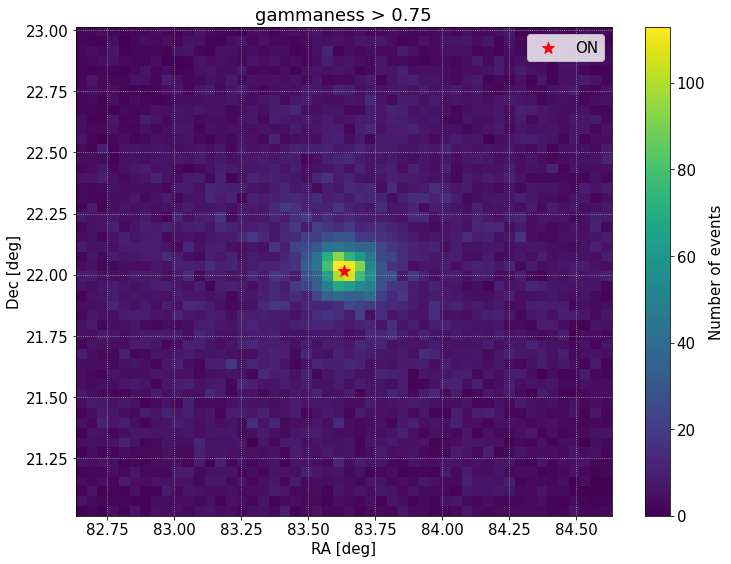

In [12]:
pyplot.figure()
pyplot.title(f'gammaness > {gamcut}')
pyplot.xlabel('RA [deg]')
pyplot.ylabel('Dec [deg]')
pyplot.xlim(xlim)
pyplot.ylim(ylim)
pyplot.axis(xlim+ylim)

bins_radec=[np.linspace(xlim[1], xlim[0], 51), np.linspace(ylim[0], ylim[1], 51)]

pyplot.hist2d(df_gamcut['reco_ra_mean'].values, df_gamcut['reco_dec_mean'].values, bins=bins_radec)
pyplot.colorbar(label='Number of events')

pyplot.scatter(
    on_coord.ra.to(u.deg).value, on_coord.dec.to(u.deg).value, 
    label='ON', marker='*', s=150, color='red'
)

pyplot.legend()
pyplot.grid()